In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Reading the files

In [3]:
X_train=pd.read_csv("Data/TrainingWiDS2021.csv")
X_test=pd.read_csv("Data/UnlabeledWiDS2021.csv")

## Data Insights

In [4]:
X_train.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
X_train.shape

(130157, 181)

We have training data consisting of 130157 samples each consisting of 180 features.  These features are the information about the patients admitted in the ICU and include BMI, Ethnicity, age and so on. Much of these features are of very low importance and our next steps would be to remove those features. The last column is the ground truth or an indicator of whether that particular patient has diabetes or not.

But before that we need to clean and preprocess our data, as it is very raw

In [6]:
X_test.shape

(10234, 180)

We have test data consisting of 10234 data points. Our task will be to make predictions for these points whose ground truth value we do not know

In [7]:
y_train=X_train["diabetes_mellitus"]

In [8]:
X_train=X_train.drop(['Unnamed: 0','encounter_id','hospital_id','diabetes_mellitus'],axis=1) #Dropping index columns cause they are irrelavant in making predictions
X_test=X_test.drop(['Unnamed: 0','encounter_id','hospital_id'],axis=1)

In [9]:
print(X_train.shape,X_test.shape)

(130157, 177) (10234, 177)


## Data Preprocessing and Cleaning

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


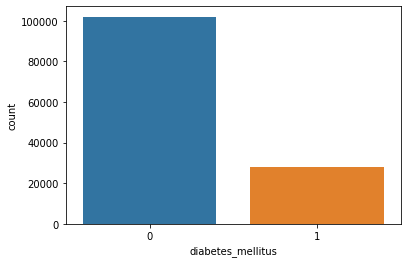

Dataset is Unbalanced


0    102006
1     28151
Name: diabetes_mellitus, dtype: int64

In [10]:
sns.countplot(y_train)
plt.show()
print('Dataset is Unbalanced')
y_train.value_counts()

The above plot shows that the training dataset is imbalanced as it should be because the proportion of patients admitted to the ICU having diabetes has to be less than the patients who do not have diabetes

Let us look at a description of the dataset through some statistics

In [11]:
X_train.describe()

,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,126694.000000,51994.000000,128472.000000,...,22712.000000,16760.000000,16760.000000,130157.00000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000
mean,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,83.791104,2.886149,185.492683,...,145.949537,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852
std,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,24.963063,0.689812,85.858208,...,100.211935,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888
min,0.000000,14.844926,0.000000,137.200000,82.000000,-0.250000,0.0,38.600000,1.200000,101.000000,...,31.000000,42.000000,38.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,23.598006,0.000000,162.500000,427.000000,0.045833,0.0,66.500000,2.400000,113.000000,...,77.000000,144.000000,138.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64.000000,27.564749,0.000000,170.100000,653.000000,0.155556,0.0,80.000000,2.900000,122.000000,...,108.000000,228.125000,218.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,32.803127,0.000000,177.800000,969.000000,0.423611,0.0,96.800000,3.400000,301.000000,...,182.000000,333.000000,324.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89.000000,67.814990,1.000000,195.590000,1111.000000,175.627778,0.0,186.000000,4.600000,308.000000,...,514.905000,720.000000,654.813793,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
missing_values=pd.DataFrame(X_train.isnull().sum()/(X_train.shape[0]))
missing_values.columns=['Missing ratio']
missing_values.sort_values(by='Missing ratio',ascending=False)

,Missing ratio
h1_bilirubin_min,0.920896
h1_bilirubin_max,0.920896
h1_albumin_min,0.914319
h1_albumin_max,0.914319
h1_lactate_min,0.910185
...,...
pre_icu_los_days,0.000000
readmission_status,0.000000
apache_post_operative,0.000000
arf_apache,0.000000


The above table shows the ratio of missing values in each of the columns of our training data. We need to handle these missing data.

For the columns having a lot of missing values(say, greater than 60 percent of total rows) we drop that column overall. For the rest missing values we simply drop that row

In [13]:
col_features=missing_values[missing_values['Missing ratio']>0.6].index
x_train=X_train.drop(labels=col_features,axis=1)
x_test=X_test.drop(labels=col_features,axis=1)

print(x_train.shape,x_test.shape)
x_train.dropna().nunique().reset_index()

(130157, 110) (10234, 110)


,index,0
0,age,74
1,bmi,4767
2,elective_surgery,2
3,ethnicity,6
4,gender,2
...,...,...
105,hepatic_failure,2
106,immunosuppression,2
107,leukemia,2
108,lymphoma,2


Next, we examine if there are any columns which consist of only one or two values for all rows, and then remove these columns as they won't be helpful in making predictions

In [14]:
count_values = x_train.dropna().nunique().reset_index()
useless_features = count_values[count_values[0]<2]["index"].to_list()

useless_features

['readmission_status', 'gcs_unable_apache']

We see that there are two such features. We remove these from our training data

In [15]:
x_train.drop(columns=useless_features, inplace = True)
x_test.drop(columns=useless_features, inplace = True)

In [16]:
print(x_train.shape,x_test.shape)

(130157, 108) (10234, 108)


Our dataset now consists of 108 features

Next, we analyze the type of features that we have; i.e, we count the number of categorical and numerical features we have in the dataset

In [17]:
categorical_features=[]
numerical_features=[]
for features in x_train.columns:
    if (x_train[features]).dtype=='O':
        categorical_features.append(features)
    elif (x_train[features]).dtype=='int' or (x_train[features]).dtype=='float':
        numerical_features.append(features)

In [18]:
print(len(categorical_features))
print(len(numerical_features))

6
89


Next, we convert the categorical values into dummy/indicator variables

In [19]:
df=pd.get_dummies(x_train[categorical_features])
x_train=pd.concat([x_train,df],axis=1)
df2=pd.get_dummies(x_test[categorical_features])
x_test=pd.concat([x_test,df2],axis=1)

print(x_train.shape,x_test.shape)

(130157, 147) (10234, 142)


We need to remove the columns which are appearing in X_train but not X_test

In [20]:
column=[]
for i in x_train.columns:
    if i not in x_test.columns:
        column.append(i)
        
column
x_train=x_train.drop(labels=column,axis=1)

In [21]:
x_train=x_train.drop(labels=categorical_features,axis=1)
x_test=x_test.drop(labels=categorical_features,axis=1)

In [22]:
x_train.shape

(130157, 136)

Now we will fill the missing values in the numerical columns with the mean of the remaining values in that column

In [23]:
for i in x_train.columns:
    if (x_train[i]).dtype=='int32' or(x_train[i]).dtype=='float64' :
        x_train[i] =x_train[i].fillna(x_train[i].mean())
        x_test[i]=x_test[i].fillna(x_train[i].mean())

Let us split the data into train and validation set now

In [24]:
X_train,X_val,Y_train,Y_val=train_test_split(x_train,y_train,test_size=0.3,stratify=y_train)
print(X_train.shape,X_val.shape)

(91109, 136) (39048, 136)


## Modeling

The first model that we fit is the Random Forest Classifier. Our main objective behind this is to get an idea about the relative feature importances so that we will be able to use only the important features for our next models

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
clf=RandomForestClassifier(n_estimators=200,verbose=2,n_jobs=-1,random_state=42,class_weight='balanced')

In [27]:
clf.fit(X_train,Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200building tree 7 of 200building tree 8 of 200


building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.8s


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   44.6s finished


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42, verbose=2)

In [28]:
feature_importances={}
for i,j in enumerate(X_train.columns):
    feature_importances[j]=clf.feature_importances_[i]

In [29]:
feature_importances

{'age': 0.01777329435201717,
 'bmi': 0.026271348274364316,
 'elective_surgery': 0.000796963705390643,
 'height': 0.008658569702626634,
 'icu_id': 0.011046075100354373,
 'pre_icu_los_days': 0.01046661074104076,
 'weight': 0.020863398960238984,
 'apache_2_diagnosis': 0.010042960065898538,
 'apache_3j_diagnosis': 0.009976613953765387,
 'apache_post_operative': 0.0008540408600786368,
 'arf_apache': 0.002443550215016735,
 'bun_apache': 0.00994465488914561,
 'creatinine_apache': 0.01193927087920986,
 'gcs_eyes_apache': 0.0028376014184987213,
 'gcs_motor_apache': 0.0029368329546219187,
 'gcs_verbal_apache': 0.003076464752743441,
 'glucose_apache': 0.07272302966195786,
 'heart_rate_apache': 0.00999059560944461,
 'hematocrit_apache': 0.008360294127893964,
 'intubated_apache': 0.0013752192005106433,
 'map_apache': 0.00839180740570297,
 'resprate_apache': 0.0080295797005415,
 'sodium_apache': 0.006778631132202839,
 'temp_apache': 0.0076877470026628265,
 'urineoutput_apache': 0.007993041953694805,

In [30]:
feature_importances_df=pd.DataFrame.from_dict(feature_importances,orient='index')

In [31]:
feature_importances_df.columns=['Significance value']

<AxesSubplot:>

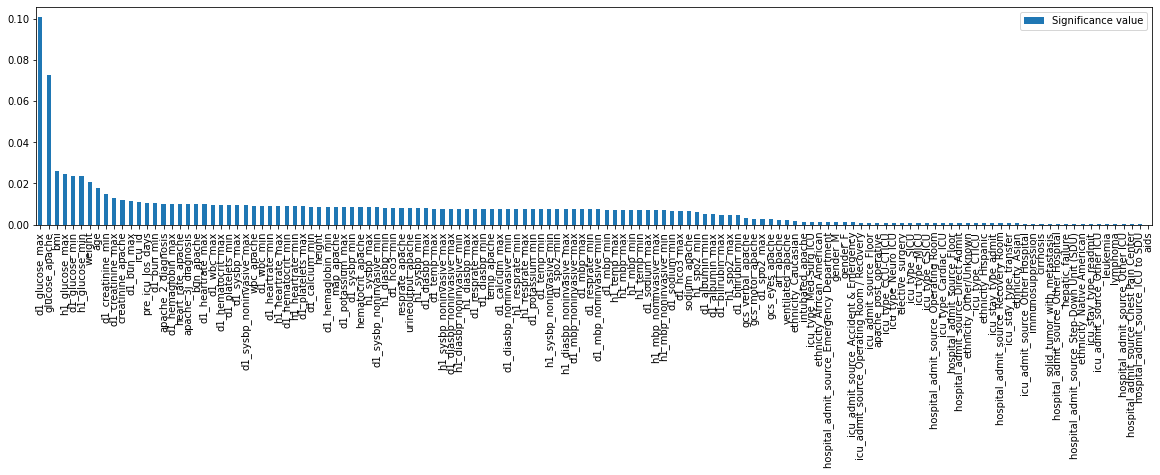

In [32]:
feature_importances_df.sort_values(by='Significance value',ascending=False).plot(kind='bar',figsize=(20, 4))

The above plot shows the relative feature importances of all the features. Notice how the importances decrease drastically as we move across the x axis. We thus decide to use only the top 10 features for training our next models. However, this is a parameter which could be changed.

In [33]:
feature_selected=feature_importances_df.sort_values(by='Significance value',ascending=False).index[0:10]

In [34]:
feature_selected

Index(['d1_glucose_max', 'glucose_apache', 'bmi', 'h1_glucose_max',
       'd1_glucose_min', 'h1_glucose_min', 'weight', 'age',
       'd1_creatinine_min', 'd1_creatinine_max'],
      dtype='object')

In [35]:
X_train_final=X_train[feature_selected]
X_val_final=X_val[feature_selected]
X_test_final=x_test[feature_selected]

In [36]:
print(X_train_final.shape,X_val_final.shape,X_test_final.shape)

(91109, 10) (39048, 10) (10234, 10)


These are the final shapes of training, validation and test datasets that we will use. Now we will train our various models on this data and analyze the results

## Model 1: Random Forest Classifier

In [37]:
clf=RandomForestClassifier(n_estimators=300,verbose=2,n_jobs=-1,random_state=42,class_weight='balanced')
clf.fit(X_train_final,Y_train)
y_pred1=clf.predict(X_val_final)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300building tree 2 of 300
building tree 3 of 300
building tree 4 of 300

building tree 5 of 300building tree 6 of 300
building tree 7 of 300building tree 8 of 300


building tree 9 of 300
building tree 10 of 300building tree 11 of 300

building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s


building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.3s


building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.2s finished


In [38]:
y_pred1=clf.predict_proba(X_val_final)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


In [39]:
y_pred1

array([[0.77666667, 0.22333333],
       [1.        , 0.        ],
       [0.56      , 0.44      ],
       ...,
       [0.99666667, 0.00333333],
       [0.64666667, 0.35333333],
       [0.78      , 0.22      ]])

The above values are the ones we predict for the validation data. These are the probabilites of belonging to class 0 and class 1 respectively

In [40]:
y_pred1[:,1]

array([0.22333333, 0.        , 0.44      , ..., 0.00333333, 0.35333333,
       0.22      ])

Now let us draw an ROC curve for the predictions 

In [41]:
fpr,tpr,thresholds=roc_curve(Y_val,y_pred1[:,1])
thresholds=thresholds[2:]

In [42]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

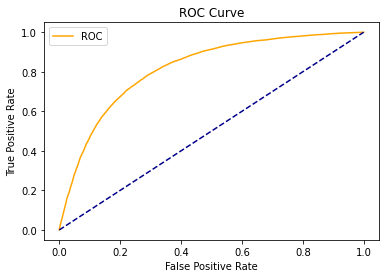

AUC : 0.8156997111173756


In [43]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,y_pred1[:,1]))

We get an AUROC score of 0.81 which indicates a pretty good fit

Next, let us try to find the best parameters for the Random Forest Classifier model

In [44]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators=np.linspace(100,1000,10,dtype=int)
weights = np.linspace(0.05, 0.95, 20)
max_depth=np.linspace(1,10,10,dtype=int)
distributions={'class_weight': [{0: x, 1: 1.0-x} for x in weights],'n_estimators':n_estimators,'max_depth':max_depth}
clf2 = RandomizedSearchCV(estimator=RandomForestClassifier(max_features='log2'),param_distributions=distributions,scoring='accuracy',cv=3,verbose=3,n_jobs=-1,random_state=42)

result = clf2.fit(X_train_final, Y_train)
print("Best parameters : %s" % result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters : {'n_estimators': 600, 'max_depth': 10, 'class_weight': {0: 0.5236842105263158, 1: 0.47631578947368425}}


In [45]:
y_pred_final=clf2.predict_proba(X_val_final)

In [46]:
fpr,tpr,thresholds=roc_curve(Y_val,y_pred_final[:,1])
thresholds=thresholds[2:]

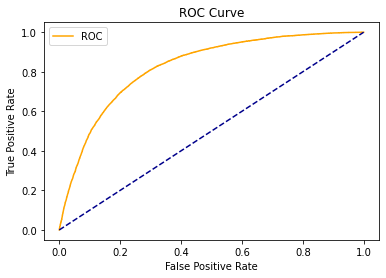

AUC : 0.8249797948157371


In [47]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,y_pred_final[:,1]))

## Model 2: GradientBoost Classifier

In [48]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators=np.linspace(100,1000,10,dtype=int)
weights = np.linspace(0.05, 0.95, 20)
max_depth=np.linspace(1,10,10,dtype=int)
distributions={'n_estimators':n_estimators,'max_depth':max_depth}
gbsc = RandomizedSearchCV(estimator=GradientBoostingClassifier(max_features='log2'),param_distributions=distributions,scoring='accuracy',cv=3,verbose=3,n_jobs=-1,random_state=42)

result = gbsc.fit(X_train_final, Y_train)
print("Best parameters : %s" % result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters : {'n_estimators': 300, 'max_depth': 3}


In [49]:
clf3=GradientBoostingClassifier(n_estimators= 300,max_depth= 3,
                                 max_features='log2',verbose=2,random_state=42)
clf3.fit(X_train_final, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0121           30.72s
         2           0.9859           32.99s
         3           0.9635           32.18s
         4           0.9456           31.81s
         5           0.9308           29.42s
         6           0.9178           27.56s
         7           0.9094           26.97s
         8           0.8992           26.17s
         9           0.8914           25.28s
        10           0.8862           25.51s
        11           0.8811           25.57s
        12           0.8756           25.01s
        13           0.8709           24.48s
        14           0.8660           24.33s
        15           0.8614           24.06s
        16           0.8576           23.77s
        17           0.8548           23.36s
        18           0.8511           23.80s
        19           0.8483           24.15s
        20           0.8453           24.11s
        21           0.8430           23.97s
        2

       186           0.7869            9.28s
       187           0.7868            9.21s
       188           0.7866            9.14s
       189           0.7865            9.06s
       190           0.7864            8.99s
       191           0.7864            8.91s
       192           0.7863            8.82s
       193           0.7863            8.73s
       194           0.7861            8.65s
       195           0.7860            8.58s
       196           0.7859            8.50s
       197           0.7859            8.41s
       198           0.7858            8.33s
       199           0.7857            8.24s
       200           0.7855            8.15s
       201           0.7855            8.07s
       202           0.7854            7.98s
       203           0.7853            7.91s
       204           0.7853            7.87s
       205           0.7851            7.78s
       206           0.7850            7.70s
       207           0.7849            7.61s
       208

GradientBoostingClassifier(max_features='log2', n_estimators=300,
                           random_state=42, verbose=2)

In [50]:
y_pred_final2=clf3.predict_proba(X_val_final)

In [51]:
fpr,tpr,thresholds=roc_curve(Y_val,y_pred_final2[:,1])
thresholds=thresholds[2:]

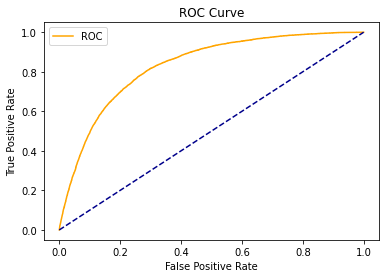

AUC : 0.8294064824944412


In [52]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,y_pred_final2[:,1]))

AUROC curve for GradientBoost Classfiier

Next, we try to make predictions taking the average of GBClassifier and RFClassifer and see if we get better results

In [53]:
classification_prob=pd.DataFrame(y_pred_final[:,1])

In [54]:
classification_prob['GB Classifier']=y_pred_final2[:,1]

In [55]:
classification_prob.columns=['RF Classifier','GB Classifier']

In [56]:
classification_prob['Overall_Avg']=(classification_prob['GB Classifier']+classification_prob['RF Classifier'])/2

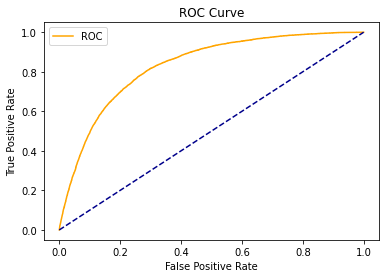

AUC : 0.8286348519486949


In [57]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,classification_prob['Overall_Avg']))

AUROC curve for combined prediction(average) of RF and GB

## Model 3: Adaboost Classifier

In [58]:
from sklearn.ensemble import AdaBoostClassifier

In [59]:
clf4=AdaBoostClassifier(n_estimators=100,learning_rate=0.8,random_state=42)

In [60]:
clf4.fit(X_train_final, Y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=42)

In [62]:
y_pred_final3=clf4.predict_proba(X_val_final)

In [63]:
classification_prob['ADABoost Classifier']=y_pred_final3[:,1]

In [64]:
fpr,tpr,thresholds=roc_curve(Y_val,y_pred_final3[:,1])
thresholds=thresholds[2:]

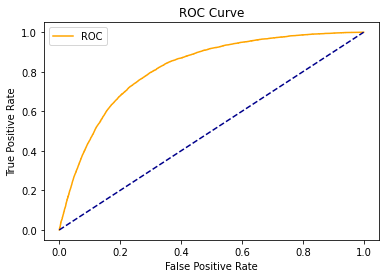

AUC : 0.8176334635732184


In [65]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,y_pred_final3[:,1]))

AUROC curver for Adaboost Classifier

Next we try to make predictions taking the average of all the three models: RF,GB and Adaboost and plot the AUC curve

In [66]:
classification_prob['Overall_Avg']=(classification_prob['GB Classifier']+classification_prob['RF Classifier']+classification_prob['ADABoost Classifier'])/3

In [67]:
classification_prob

,RF Classifier,GB Classifier,Overall_Avg,ADABoost Classifier
0,0.229700,0.217099,0.313944,0.495032
1,0.039931,0.044394,0.191945,0.491510
2,0.344385,0.365506,0.402426,0.497388
3,0.087522,0.048511,0.209599,0.492764
4,0.361081,0.456615,0.438702,0.498409
...,...,...,...,...
39043,0.056959,0.063400,0.203591,0.490415
39044,0.060361,0.065453,0.205589,0.490952
39045,0.019850,0.021565,0.177010,0.489614
39046,0.348066,0.312281,0.385971,0.497566


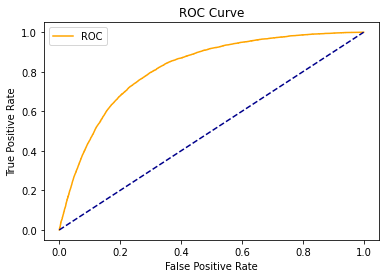

AUC : 0.8286363416427112


In [68]:
plot_roc_curve(fpr, tpr)
print('AUC :',roc_auc_score(Y_val,classification_prob['Overall_Avg']))

AUROC curve for average of all the predictions

## Model 4: XGBoost

In [77]:
a=np.linspace(0.1,0.99,10)
b=np.linspace(0.1,0.99,10)
c=np.linspace(0.1,0.99,10)


In [78]:
values={}
for i in a:
    for j in b:
        for k in c:
            s=(i+j+k)
            classification_prob['Overall_Avg']=((i/s)*classification_prob['GB Classifier']+(j/s)*classification_prob['RF Classifier']
                                        +(k/s)*classification_prob['ADABoost Classifier'])
            
            values[(i,j,k)]=roc_auc_score(Y_val,classification_prob['Overall_Avg'])

In [79]:
Keymax = max(values, key=values.get) 
print(Keymax) 

(0.99, 0.1, 0.1)


In [80]:
values[Keymax]

0.8294558436024037

In [81]:
total=sum(Keymax)

In [84]:
y_test_pred_ADB=clf4.predict_proba(X_test_final)[:,1]

In [86]:
y_test_pred_GB=clf3.predict_proba(X_test_final)[:,1]

In [87]:
y_test_pred_RF=clf2.predict_proba(X_test_final)[:,1]

In [88]:
final_clf_op=pd.DataFrame(y_test_pred_GB)

In [89]:
final_clf_op['RF']=y_test_pred_RF

In [90]:
final_clf_op['ADB']=y_test_pred_ADB

In [91]:
final_clf_op.columns=['GB','RF','ADB']

In [92]:
final_clf_op['Overall_Avg']=((Keymax[0]/total)*final_clf_op['GB']+
                             (Keymax[1]/total)*final_clf_op['RF']
                             +(Keymax[2]/total)*final_clf_op['ADB'])

In [93]:
final_clf_op

,GB,RF,ADB,Overall_Avg
0,0.100450,0.091166,0.491843,0.132560
1,0.125571,0.100666,0.494354,0.154468
2,0.186175,0.163663,0.496840,0.210390
3,0.083142,0.098399,0.491589,0.118747
4,0.220461,0.153538,0.495231,0.237927
...,...,...,...,...
10229,0.052597,0.091466,0.488876,0.092526
10230,0.048381,0.071617,0.490322,0.087471
10231,0.066887,0.074730,0.492437,0.103306
10232,0.019904,0.029398,0.486237,0.059889


In [107]:
encounter_IDs = pd.read_csv("Data/UnlabeledWiDS2021.csv")[["encounter_id"]].values

In [108]:
df_sub = {'encounter_id': encounter_IDs[:,0], 'diabetes_mellitus':final_clf_op['Overall_Avg']} 

In [109]:
XGBoost_of_auroc=[]

In [110]:
df_predictions = pd.DataFrame.from_dict(df_sub).set_index(['encounter_id'])
df_predictions.to_csv('submission_final.csv')

K fold cross validation with XGBoost

In [111]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

K_FOLDS = 5

def train_model_kfold_cv(X, y, X_test):
    
    skf = StratifiedKFold(n_splits = K_FOLDS, random_state = 1, shuffle = True)
    index = 0
    model_predict = np.zeros((len(X_test), 2))
    
    for train, val in skf.split(X, y):
        
        X_train_cv, X_val_cv = X.values[train], X.values[val]
        y_train_cv, y_val_cv = y.values[train], y.values[val]
        
        xgboost = XGBClassifier(learning_rate=0.1, n_estimators=500, tree_method='gpu_hist', eval_metric='auc')
        
        print('--------------------------------------------------')
        print(f'Training on fold {index+1}')
        print('--------------------------------------------------')
        
        xgboost.fit(X_train_cv, y_train_cv)
        y_preds = xgboost.predict(X_val_cv)
        score = roc_auc_score(y_preds, y_val_cv)
        XGBoost_of_auroc.append(score)
        print(f'AUROC score on fold {index+1}: {score}')
        
        prediction = xgboost.predict_proba(X_test.values[:])
        model_predict+= prediction/K_FOLDS
        index += 1
        
    return model_predict    

In [112]:
X_val_final.head()

,d1_glucose_max,glucose_apache,bmi,h1_glucose_max,d1_glucose_min,h1_glucose_min,weight,age,d1_creatinine_min,d1_creatinine_max
50149,114.000000,106.000000,44.827412,167.702625,114.00000,158.908794,111.200000,83.0,4.100000,4.100000
49431,174.149802,160.141416,18.294646,167.702625,114.44031,158.908794,61.200000,57.0,1.363795,1.493531
111661,186.000000,161.000000,40.147694,186.000000,99.00000,145.000000,116.300000,62.0,0.780000,0.780000
7350,141.000000,141.000000,43.841420,167.702625,122.00000,158.908794,127.000000,35.0,0.950000,1.290000
4666,222.000000,222.000000,29.110260,142.000000,142.00000,142.000000,83.791104,63.0,0.900000,0.900000


In [113]:
X_train_final.shape

(91109, 10)

Making final predictions with XGBoost

In [114]:
predictions = train_model_kfold_cv(X_train_final,Y_train, X_test_final)

--------------------------------------------------
Training on fold 1
--------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUROC score on fold 1: 0.7112836925040131
--------------------------------------------------
Training on fold 2
--------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUROC score on fold 2: 0.7193872602327636
--------------------------------------------------
Training on fold 3
--------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUROC score on fold 3: 0.7159291457596897
--------------------------------------------------
Training on fold 4
--------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUROC score on fold 4: 0.7020250366000306
--------------------------------------------------
Training on fold 5
--------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUROC score on fold 5: 0.7166473269587925


Average AUC : 0.7130544924110579


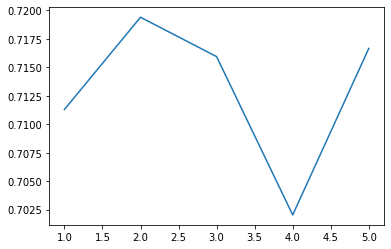

In [115]:
folds=[1,2,3,4,5]
plt.plot(folds,XGBoost_of_auroc)
print('Average AUC :',sum(XGBoost_of_auroc)/5)

In [121]:
X_test=pd.read_csv("Data/UnlabeledWiDS2021.csv")

In [122]:
test_submission = pd.DataFrame(X_test["encounter_id"])
test_submission["diabetes_mellitus"] = predictions[:, 1]
test_submission

,encounter_id,diabetes_mellitus
0,144740,0.137211
1,141990,0.136557
2,142038,0.153607
3,138628,0.087643
4,141682,0.316193
...,...,...
10229,143750,0.053650
10230,143813,0.037801
10231,137126,0.082233
10232,135652,0.015927


In [123]:
test_submission.to_csv("xgb_v39.csv",index=False)

## Model 5: CatBoost 

In [124]:
import catboost
from catboost import CatBoost, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [125]:
!pip install imbalanced-learn

# check version number
import imblearn
print(imblearn.__version__)

You should consider upgrading via the 'C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.


0.9.0


In [126]:
X_test_final.head()
X_test_final.columns

Index(['d1_glucose_max', 'glucose_apache', 'bmi', 'h1_glucose_max',
       'd1_glucose_min', 'h1_glucose_min', 'weight', 'age',
       'd1_creatinine_min', 'd1_creatinine_max'],
      dtype='object')

In [127]:
X_train_temp=X_train_final.astype(np.int64)
X_test_temp=X_test_final.astype(np.int64)

In [128]:
columns = []
columns_index = []
for i, col in enumerate(X_train_temp.columns):
   
    if X_train_temp[col].dtypes == np.object or X_train_temp[col].dtypes == np.int64:
        columns.append(col)
        columns_index.append(i)


<ipython-input-128-6430c5f0f819>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if X_train_temp[col].dtypes == np.object or X_train_temp[col].dtypes == np.int64:


In [129]:
X_train_temp.fillna("0")
Y_train_temp=Y_train
Y_train_temp.fillna("0")

54214    0
96323    0
95540    0
79988    1
16208    0
        ..
15718    0
88295    0
47670    1
20378    0
46309    0
Name: diabetes_mellitus, Length: 91109, dtype: int64

In [131]:
cb_model = CatBoostClassifier(iterations = 200, learning_rate = 0.2, depth = 6, 
                              loss_function = 'CrossEntropy')

cb_model.fit(X_train_temp, Y_train_temp, columns)

preds = cb_model.predict_proba(X_train_temp)
roc = roc_auc_score(Y_train_temp, preds[:,1])
roc

0:	learn: 0.5787508	total: 373ms	remaining: 1m 14s
1:	learn: 0.5149091	total: 478ms	remaining: 47.3s
2:	learn: 0.4799026	total: 619ms	remaining: 40.6s
3:	learn: 0.4583406	total: 782ms	remaining: 38.3s
4:	learn: 0.4445884	total: 894ms	remaining: 34.9s
5:	learn: 0.4359129	total: 1.02s	remaining: 33.1s
6:	learn: 0.4292495	total: 1.12s	remaining: 31s
7:	learn: 0.4249900	total: 1.28s	remaining: 30.7s
8:	learn: 0.4217422	total: 1.39s	remaining: 29.4s
9:	learn: 0.4196396	total: 1.47s	remaining: 27.9s
10:	learn: 0.4169341	total: 1.64s	remaining: 28.2s
11:	learn: 0.4155328	total: 1.8s	remaining: 28.3s
12:	learn: 0.4141202	total: 2.05s	remaining: 29.5s
13:	learn: 0.4135588	total: 2.2s	remaining: 29.2s
14:	learn: 0.4120388	total: 2.34s	remaining: 28.9s
15:	learn: 0.4114168	total: 2.5s	remaining: 28.7s
16:	learn: 0.4106523	total: 2.62s	remaining: 28.2s
17:	learn: 0.4101364	total: 2.81s	remaining: 28.4s
18:	learn: 0.4095083	total: 3.02s	remaining: 28.7s
19:	learn: 0.4091456	total: 3.26s	remaining: 

161:	learn: 0.3927414	total: 33.1s	remaining: 7.77s
162:	learn: 0.3926300	total: 33.3s	remaining: 7.56s
163:	learn: 0.3925640	total: 33.5s	remaining: 7.36s
164:	learn: 0.3924915	total: 33.8s	remaining: 7.17s
165:	learn: 0.3923866	total: 34s	remaining: 6.97s
166:	learn: 0.3922831	total: 34.2s	remaining: 6.76s
167:	learn: 0.3922507	total: 34.4s	remaining: 6.56s
168:	learn: 0.3921855	total: 34.7s	remaining: 6.36s
169:	learn: 0.3921486	total: 35s	remaining: 6.17s
170:	learn: 0.3921096	total: 35.2s	remaining: 5.97s
171:	learn: 0.3920727	total: 35.4s	remaining: 5.76s
172:	learn: 0.3920148	total: 35.7s	remaining: 5.57s
173:	learn: 0.3919200	total: 35.9s	remaining: 5.37s
174:	learn: 0.3918405	total: 36.2s	remaining: 5.17s
175:	learn: 0.3917470	total: 36.4s	remaining: 4.96s
176:	learn: 0.3916386	total: 36.6s	remaining: 4.75s
177:	learn: 0.3915049	total: 37s	remaining: 4.57s
178:	learn: 0.3914744	total: 37.3s	remaining: 4.38s
179:	learn: 0.3913725	total: 37.7s	remaining: 4.19s
180:	learn: 0.3913

0.8433444392822661

The Catboost model has an AUROC score of 0.84, which is better than almost all the other methods we discussed above

In [133]:
pd.DataFrame({'encounter_id':X_test['encounter_id'].values,
    'diabetes_mellitus':cb_model.predict_proba(X_test_temp)[:,1]}).to_csv('catBoost.csv',
                                                                   index=False)